# Building Fusion model

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard
from tensorboard.plugins.hparams import api as hp
import datetime

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import keras

In [2]:
# build_rgb_stream
class Build_Fusion_Model:
    # build_ssd
    def build_ssd_stream(self):
        base_model = MobileNetV2(input_shape=(320, 320, 3), include_top=False, weights='imagenet')
        # Freeze the base model layers
        for layer in base_model.layers:
            layer.trainable = False
        
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu', name='ssd_dense_1')(x)
        x = Dense(256, activation='relu', name='ssd_dense_2')(x)
        x = layers.Dropout(0.5)(x)

        self.model = Model(inputs=base_model.input, outputs=x)
        # print(self.model.summary())
        return self.model
    
    # build_pose_stream
    def build_pose_stream(self,input_shape=(20, 17*2)):

        trained_lstm = load_model('models/detector_combined.h5')
        for l in trained_lstm.layers[:-3]:
            l.trainable = False
        self.model = Model(trained_lstm.input, trained_lstm.layers[-4].output)
        # print(self.model.summary())

        return self.model

# build_fusion_model
    def build_fusion_model(self,ssd_stream, pose_stream, num_classes):
        # Combine the two streams
        self.ssd_stream_flattened = layers.Flatten()(ssd_stream.output)
        self.pose_stream_flattened = layers.Flatten()(pose_stream.output)
        combined_input = layers.concatenate([self.pose_stream_flattened, self.ssd_stream_flattened])

        # Add fully connected layers for fusion
        self.fusion_dense = layers.Dense(512, activation='relu', name='fusion_dense_1')(combined_input) # replace with (combined_input)
        self.fusion_dense = layers.Dropout(0.5)(self.fusion_dense)

        self.fusion_output = layers.Dense(num_classes, activation='sigmoid', name='fusion_dense_output')(self.fusion_dense)

        # Create the final model
        self.fusion_model = models.Model(inputs=[pose_stream.input, ssd_stream.input], outputs=self.fusion_output)

        return self.fusion_model

In [3]:
# Set the number of classes for your action recognition task
num_classes = 1
build_model = Build_Fusion_Model()
# Build the RGB stream
ssd_stream = build_model.build_ssd_stream()

# Build the Pose stream
pose_stream = build_model.build_pose_stream(input_shape=(10, 34))

# Build the Fusion model
fusion_model = build_model.build_fusion_model(ssd_stream, pose_stream, num_classes)


# Define hyperparameters
hp_epochs = hp.HParam('epochs', hp.IntInterval(10, 50))
hp_learning_rate = hp.HParam('learning_rate', hp.RealInterval(1e-4, 1e-2))

# Create a summary file for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Create a callback for hyperparameter logging
hparams_callback = hp.KerasCallback(log_dir, hparams={hp_epochs: 20, hp_learning_rate: 1e-3})


#Checkpoints
checkpoint_filepath = 'models/ckpt/{epoch:02d}-{val_loss:.2f}.keras5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Early stoping
early_stoping = keras.callbacks.EarlyStopping()

# Compile the model with an appropriate optimizer, loss, and metrics
optimizer = keras.optimizers.Adam()
fusion_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Display the model summary
# fusion_model.summary()


In [4]:
# tf.keras.utils.plot_model(fusion_model, show_shapes=True, show_layer_names=True)

In [5]:
fusion_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 160, 160, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 160, 160, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [6]:
fusion_model.output_shape

(None, 1)

# Inference

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from video_processor import VideoProcessor

In [8]:
df = pd.read_csv('../datasets/KTH/dataset.csv')
df.head()

,clip_path,label
0,../datasets/KTH/boxing\person01_boxing_d1_unco...,boxing
1,../datasets/KTH/boxing\person01_boxing_d2_unco...,boxing
2,../datasets/KTH/boxing\person01_boxing_d3_unco...,boxing
3,../datasets/KTH/boxing\person01_boxing_d4_unco...,boxing
4,../datasets/KTH/boxing\person02_boxing_d1_unco...,boxing


In [9]:
df['label'].unique()

array(['boxing', 'handclapping', 'handwaving', 'jogging', 'running', 'walking'], dtype=object)

In [10]:
def three_class(x):
    if x not in ['golf', 'kick_ball', 'pushup', 'shoot_ball',  
             'shoot_bow', 'shoot_gun', 'swing_baseball', 
             'thow', 'BoxingPunchingBag', 'boxing', 'punch', 
             'kick', 'point', 'handwaving', 'wave']:
        return 0
    else:
        return 1

In [11]:
df['label'] = df['label'].apply(three_class)

In [12]:
classwise_df = []

for i in df['label'].unique():
    classwise_df.append(df[df['label']==i].reset_index())

# Inference on Dataset

In [13]:
from ultralytics import YOLO
import cv2

In [14]:
model = YOLO('models/yolov8m-pose.pt') 

In [15]:
total_df = pd.DataFrame()
for df in classwise_df:
    total_df = pd.concat([total_df, df])


In [16]:
for i, d in total_df.sample(5).groupby('label'):
    print(d)

     index                                          clip_path  label
300    500  ../datasets/KTH/walking\person01_walking_d2_un...      0
159    359  ../datasets/KTH/jogging\person16_jogging_d1_un...      0
23     123  ../datasets/KTH/handclapping\person06_handclap...      0
    index                                          clip_path  label
82     82  ../datasets/KTH/boxing\person21_boxing_d3_unco...      1
43     43  ../datasets/KTH/boxing\person11_boxing_d4_unco...      1


# Training

In [17]:
import cv2
import numpy as np
import pandas as pd
from random import shuffle
import os

def data_generator(total_df, batch_size=1, shuffle_data=True, resize=320):
    """
    Yields the next training batch.
    Suppose `total_df` is a pandas DataFrame with columns 'clip_path' and 'label'.
    """
    num_samples = len(total_df)
    samples = list(total_df.iterrows())  # Convert DataFrame to a list of (index, row) tuples

    while True:  # Loop forever so the generator never terminates
        if shuffle_data:
            shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise pose_buffer and labels arrays for this batch
            pose_buffer = []
            rbg_buffer = []
            labels = []

            # For each example
            for _, batch_sample in batch_samples:
                # Load video (X) and label (y)
                vid_path = batch_sample['clip_path']
                label = batch_sample['label']
                cap = cv2.VideoCapture(vid_path)
                frame_buffer = []
                while True:
                    ret, frame = cap.read()
                    if not ret:
                        cap.release()
                        break

                    frame = cv2.resize(frame, (resize, resize))
                    if len(frame_buffer) < 10:
                        frame_buffer.append(frame)
                    elif len(frame_buffer) == 10:
                        batch = vp.process_video(frame_buffer)
                        batch = np.array(batch)[:, 0, :].reshape(-1, 10, 34)
                        pose_buffer.append(batch[0])
                        rbg_buffer.append(frame)
                        frame_buffer = []
                        labels.append(label)
                    else:
                        frame_buffer = []

                # labels.extend([label] * len(pose_buffer))  # Extend the labels list for this video's frames

            # Make sure they're numpy arrays (as opposed to lists)
            pose_buffer = np.array(pose_buffer)
            rbg_buffer = np.array(rbg_buffer)
            labels = np.array(labels)
            # print(len(labels))


            # res = [pose_buffer, rbg_buffer], labels
            # print(res[0][0].shape, res[0][1].shape, res[1].shape)

            # The generator-y part: yield the next training batch
            yield [pose_buffer, rbg_buffer], labels  # ([(None, 10, 34), (None, 640, 640, 3)], (None,1))


In [18]:
vp = VideoProcessor(model, max_frames=100, img_sz=320, show_stream=False)

In [19]:
from sklearn.model_selection import train_test_split

# total_df = total_df[:10]
train_df, test_df = train_test_split(total_df, test_size=0.2, random_state=42)
train_df, val_df  = train_test_split(total_df, test_size=0.25, random_state=42)


In [20]:
# from keras.models import load_model
# fusion_model = load_model("models/ckpt/01-0.51.keras5")

In [21]:
batch_size = 1
num_epochs = 27
train_generator = data_generator(train_df, batch_size=batch_size)
val_generator = data_generator(val_df, batch_size=1)
steps_per_epoch = len(total_df) // batch_size //2
# steps_per_epoch = 2
# Now, you can use this generator to train your model
history = fusion_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs,
                           validation_data = val_generator, validation_steps=15,
                           callbacks=[model_checkpoint_callback])

Epoch 1/27
299/299 [==============================] - ETA: 0s - loss: 0.5839 - accuracy: 0.7716

INFO:tensorflow:Assets written to: models/ckpt\01-0.30.keras5\assets


INFO:tensorflow:Assets written to: models/ckpt\01-0.30.keras5\assets


299/299 [==============================] - 1127s 4s/step - loss: 0.5839 - accuracy: 0.7716 - val_loss: 0.3029 - val_accuracy: 0.8589
Epoch 2/27
299/299 [==============================] - 796s 3s/step - loss: 0.3586 - accuracy: 0.8545 - val_loss: 0.3549 - val_accuracy: 0.8344
Epoch 3/27
299/299 [==============================] - 802s 3s/step - loss: 0.2995 - accuracy: 0.8621 - val_loss: 0.4574 - val_accuracy: 0.7833
Epoch 4/27
299/299 [==============================] - 876s 3s/step - loss: 0.3151 - accuracy: 0.8625 - val_loss: 0.2643 - val_accuracy: 0.8557
Epoch 5/27
299/299 [==============================] - 876s 3s/step - loss: 0.2582 - accuracy: 0.8887 - val_loss: 0.2879 - val_accuracy: 0.8488
Epoch 6/27
299/299 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.8720

INFO:tensorflow:Assets written to: models/ckpt\06-0.31.keras5\assets


INFO:tensorflow:Assets written to: models/ckpt\06-0.31.keras5\assets


299/299 [==============================] - 1239s 4s/step - loss: 0.3023 - accuracy: 0.8720 - val_loss: 0.3077 - val_accuracy: 0.8875
Epoch 7/27
299/299 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.8767

INFO:tensorflow:Assets written to: models/ckpt\07-0.17.keras5\assets


INFO:tensorflow:Assets written to: models/ckpt\07-0.17.keras5\assets


299/299 [==============================] - 1159s 4s/step - loss: 0.2747 - accuracy: 0.8767 - val_loss: 0.1695 - val_accuracy: 0.9416
Epoch 8/27
299/299 [==============================] - 786s 3s/step - loss: 0.2456 - accuracy: 0.8997 - val_loss: 0.2477 - val_accuracy: 0.8746
Epoch 9/27
299/299 [==============================] - 809s 3s/step - loss: 0.2717 - accuracy: 0.8819 - val_loss: 0.1594 - val_accuracy: 0.9082
Epoch 10/27
299/299 [==============================] - ETA: 0s - loss: 0.2707 - accuracy: 0.8762

INFO:tensorflow:Assets written to: models/ckpt\10-0.13.keras5\assets


INFO:tensorflow:Assets written to: models/ckpt\10-0.13.keras5\assets


299/299 [==============================] - 814s 3s/step - loss: 0.2707 - accuracy: 0.8762 - val_loss: 0.1273 - val_accuracy: 0.9755
Epoch 11/27
299/299 [==============================] - 825s 3s/step - loss: 0.2253 - accuracy: 0.9065 - val_loss: 0.3539 - val_accuracy: 0.8197
Epoch 12/27
299/299 [==============================] - 811s 3s/step - loss: 0.2361 - accuracy: 0.8985 - val_loss: 0.6019 - val_accuracy: 0.8593
Epoch 13/27
299/299 [==============================] - 803s 3s/step - loss: 0.2316 - accuracy: 0.8972 - val_loss: 0.5083 - val_accuracy: 0.8020
Epoch 14/27
299/299 [==============================] - 804s 3s/step - loss: 0.2144 - accuracy: 0.9054 - val_loss: 0.2645 - val_accuracy: 0.8900
Epoch 15/27
299/299 [==============================] - 803s 3s/step - loss: 0.2345 - accuracy: 0.8975 - val_loss: 0.2803 - val_accuracy: 0.8614
Epoch 16/27
299/299 [==============================] - 798s 3s/step - loss: 0.2108 - accuracy: 0.9098 - val_loss: 0.2361 - val_accuracy: 0.8756
Epoc

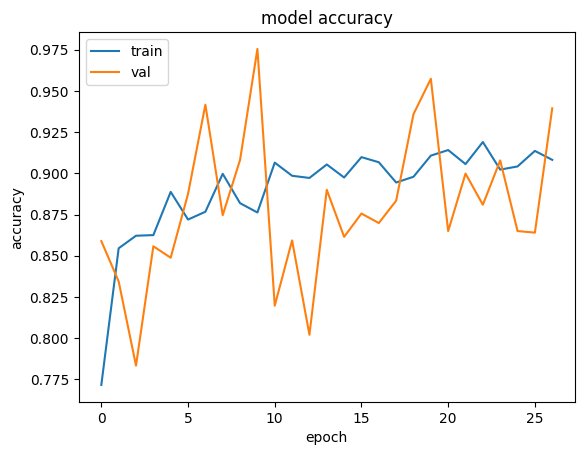

In [23]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])   
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
import pickle 
with open('models/ckpt/trainHistoryDict_3to30', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# with open('models/ckpt/trainHistoryDict', "rb") as file_pi:
#     history = pickle.load(file_pi)

In [24]:
fusion_model.save('models/VGG_POSE.keras')

In [26]:
from keras.models import load_model
fusion_model = load_model("models/VGG_POSE.keras")

In [27]:
from tabnanny import verbose
import cv2
import numpy as np
from video_processor import VideoProcessor
from ultralytics import YOLO

model = YOLO('models/yolov8m-pose.pt') 
vp = VideoProcessor(model, max_frames=100, img_sz=320, show_stream=False)

def predict_from_camera(model, resize=320, frame_buffer_size=10, buffer_size=10):
    """
    Captures frames from the camera, processes them, and makes predictions using the provided model.
    
    Parameters:
    - model: The trained model used for prediction.
    - resize: The size to which frames will be resized.
    - frame_buffer_size: The number of frames to buffer before processing.
    """
    cap = cv2.VideoCapture("examples/videos/person01_boxing_d1_uncomp.avi") # 0 is the default camera
    frame_buffer = np.zeros((1, 320, 320, 3))
    keypoints_buffer = np.zeros((10,1,34))  

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Resize the frame
            frame = cv2.resize(frame, (resize, resize))

            # Add the frame to the buffer
            if keypoints_buffer.shape[1] != buffer_size:
                keypoints_batch = vp.process_image(frame)

                keypoints_buffer = np.concatenate((keypoints_buffer, keypoints_batch), axis=1)
                frame_buffer = np.concatenate((frame_buffer, np.expand_dims(frame, 0)), axis=0)
                # print(keypoints_buffer.shape)
                
            else:
                # Process the video frames (assuming vp.process_video is defined elsewhere)
                keypoints_batch = vp.process_video(frame)
                if keypoints_buffer.shape[1] + keypoints_batch.shape[1] > buffer_size:
                    excess_size = keypoints_buffer.shape[1] + keypoints_batch.shape[1] - buffer_size
                    keypoints_buffer = keypoints_buffer[:, excess_size:, :]
               
                keypoints_buffer = np.concatenate((keypoints_buffer, keypoints_batch), axis=1)

                # frame_buffer = np.concatenate((frame_buffer, np.expand_dims(frame, 0)), axis=0)

                # Make predictions using the model
                print(keypoints_buffer.shape, frame_buffer.shape)
                print(model.input_shape)
                predictions = model.predict([keypoints_buffer, frame_buffer], verbose=False)

                for id, person in enumerate(vp.data[0]):
                    x1 = int(person['box']['x1'])
                    y1 = int(person['box']['y1'])
                    x2 = int(person['box']['x2'])
                    y2 = int(person['box']['y2'])

                    color = (0,0,255) if predictions[id][0] > 0.6 else (0,255,0)             
                    frame = cv2.rectangle(frame, (x1,y1), (x2,y2), color, 5)


                print(predictions)

            if cv2.waitKey(1)==27:
                break
            cv2.imshow("output", frame)

                # Clear the frame buffer for the next batch of frames


    finally:
        cap.release()
        cv2.destroyAllWindows()

# Example usage:
# Assuming `model` is your trained model
predict_from_camera(fusion_model, buffer_size = fusion_model.input_shape[0][1])


Error processing Image: 'persistant' is not a valid YOLO argument. 

    Arguments received: ['yolo', '--f=c:\\Users\\aniru\\AppData\\Roaming\\jupyter\\runtime\\kernel-v2-20580s4NnYp10FhJU.json']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of {'classify', 'obb', 'pose', 'detect', 'segment'}
                MODE (required) is one of {'export', 'train', 'val', 'track', 'predict', 'benchmark'}
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
                    See all ARGS at https://docs.ultralytics.com/usage/cfg or with 'yolo cfg'

    1. Train a detection model for 10 epochs with an initial learning_rate of 0.01
        yolo train data=coco128.yaml model=yolov8n.pt epochs=10 lr0=0.01

    2. Predict a YouTube video using a pretrained segmentation model at image size 320:
        yolo predict model=yolov8n-seg.pt source='https://youtu.be/LNw

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 0 dimension(s)

In [12]:
fusion_model.input_shape[0][1]

10